In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import json
import nltk
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /Users/ajaymdn/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
def clean_text(text):
    # Ensure consistent spacing after titles like "Item 1A."
    text = re.sub(r'(Item\s*\d+[A-Za-z]*)\.', r'\1. ', text)
    # Insert missing spaces between concatenated words like "FactorsThe"
    text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)
    # Clean up spacing after punctuation
    text = re.sub(r'(?<=[.!?])(?=\S)', r' ', text)
    return text.strip()

In [4]:
def split_sentences_with_nltk(text):
    # Initial cleaning
    text = clean_text(text)

    # Use nltk's sentence tokenizer
    sentences = nltk.sent_tokenize(text)

    # Post-process to remove redundant or empty sentences
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]
    return sentences

In [6]:
def converttotext(url):
    headers = {'User-Agent':'Sample Company Name AdminContact@<sample company domain>.com','Accept-Encoding':'gzip, deflate','Host':'www.sec.gov'}

    r = requests.get(url, headers=headers)

    raw_10k = r.text

    doc_start_pattern = re.compile(r'<DOCUMENT>')
    doc_end_pattern = re.compile(r'</DOCUMENT>')
    type_pattern = re.compile(r'<TYPE>[^\n]+')

    doc_start_is = [x.end() for x in doc_start_pattern.finditer(raw_10k)]
    doc_end_is = [x.start() for x in doc_end_pattern.finditer(raw_10k)]

    doc_types = [x[len('<TYPE>'):] for x in type_pattern.findall(raw_10k)]

    document = {}
    
    for doc_type, doc_start, doc_end in zip(doc_types, doc_start_is, doc_end_is):
        if doc_type == '10-K':
            document[doc_type] = raw_10k[doc_start:doc_end]

    regex = re.compile(r'(>Item(\s|&#160;|&nbsp;)(1A|1B|7A|7|8)\.{0,1})|(ITEM\s(1A|1B|7A|7|8))')

    matches = regex.finditer(document['10-K'])

    test_df = pd.DataFrame([(x.group(), x.start(), x.end()) for x in matches])

    test_df.columns = ['item', 'start', 'end']
    test_df['item'] = test_df.item.str.lower()
    test_df.head()
    test_df.replace('&#160;',' ',regex=True,inplace=True)
    test_df.replace('&nbsp;',' ',regex=True,inplace=True)
    test_df.replace(' ','',regex=True,inplace=True)
    test_df.replace('\.','',regex=True,inplace=True)
    test_df.replace('>','',regex=True,inplace=True)

    pos_dat = test_df.sort_values('start', ascending=True).drop_duplicates(subset=['item'], keep='last')
    pos_dat.set_index('item', inplace=True)

    item_1a_raw = document['10-K'][pos_dat['start'].loc['item1a']:pos_dat['start'].loc['item1b']]

    item_1a_content = BeautifulSoup(item_1a_raw, 'lxml')

    item_1a_text = item_1a_content.get_text()

    # def clean_text(text):
    #     text = re.sub(r'(Item\s*\d+[A-Za-z]*)\.', r'\1. ', text)
    #     text = re.sub(r'(?<=[.!?])(?=\S)', r' ', text)
    #     return text.strip()

    # item_1a_text_cleaned = clean_text(item_1a_text)

    # item_1a_text_cleaned = re.sub(r'(?<=[.!?])(?=\S)', r' ', item_1a_text_cleaned)


    # sentence_splitter = re.compile(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<!\.\.\.)(?<=\.|\?)\s')

    # sentences = sentence_splitter.split(item_1a_text_cleaned)
    # sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    sentences = split_sentences_with_nltk(item_1a_text)
    
    return sentences


In [76]:
# sentences = converttotext('https://www.sec.gov/Archives/edgar/data/0001018724/000101872424000008/0001018724-24-000008.txt')
# print(len(sentences))
# finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
# tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
# nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer)
# results = nlp(sentences)

# environment_score = [entry['score'] for entry in results if entry['label'] == 'Environmental']
# social_score = [entry['score'] for entry in results if entry['label'] == 'Social']
# governance_score = [entry['score'] for entry in results if entry['label'] == 'Governance']

# environment_score_avg = sum(environment_score) / len(environment_score) if environment_score else 0
# social_score_avg = sum(social_score) / len(social_score) if social_score else 0
# governance_score_avg = sum(governance_score) / len(governance_score) if governance_score else 0

# print(f'Average Environmental Score: {environment_score_avg}')
# print(f'Average Social Score: {social_score_avg}')
# print(f'Average Governance Score: {governance_score_avg}')

In [7]:
def calculate_average_esg(sentences, nlp):
    results = nlp(sentences)

    # Extract scores for each category
    environment_score = [entry['score'] for entry in results if entry['label'] == 'Environmental']
    social_score = [entry['score'] for entry in results if entry['label'] == 'Social']
    governance_score = [entry['score'] for entry in results if entry['label'] == 'Governance']

    # Calculate averages or set to 0 if no scores are found
    environment_score_avg = sum(environment_score) / len(environment_score) if environment_score else 0
    social_score_avg = sum(social_score) / len(social_score) if social_score else 0
    governance_score_avg = sum(governance_score) / len(governance_score) if governance_score else 0

    return {
        'environment_score_avg': environment_score_avg,
        'social_score_avg': social_score_avg,
        'governance_score_avg': governance_score_avg
    }

In [29]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer, truncation=True, max_length=512)

target_year = 2024

# with open(f"../Edgar/10K-URL/All_10K_Filings_{target_year}.json", "r") as read_file:
#     companies = json.load(read_file)

# valid_companies = []

# for company in companies:
#     try:
#         print(f"Analysing: {company['company']}")
#         sentences = converttotext(company['url'])
#         print(f"Number of sentences: {len(sentences)}")

#         if len(sentences) > 10:
#             scores = calculate_average_esg(sentences, nlp)
        
#             company['environment_score_avg'] = scores['environment_score_avg']
#             company['social_score_avg'] = scores['social_score_avg']
#             company['governance_score_avg'] = scores['governance_score_avg']
        
#             valid_companies.append(company)

#     except Exception as e:
#         print(f"Error processing {company['company']}: {e}")

# final_companies = [company['company'] for company in valid_companies]
# print(f"Companies processed: {final_companies}")

# if valid_companies:
#     environment_avg = sum([company['environment_score_avg'] for company in valid_companies]) / len(valid_companies)
#     social_avg = sum([company['social_score_avg'] for company in valid_companies]) / len(valid_companies)
#     governance_avg = sum([company['governance_score_avg'] for company in valid_companies]) / len(valid_companies)

#     print(f'Average Environmental Score: {environment_avg}')
#     print(f'Average Social Score: {social_avg}')
#     print(f'Average Governance Score: {governance_avg}')
# else:
#     print("No valid companies to calculate averages.")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [30]:
finbert = BertForSequenceClassification.from_pretrained('yiyanghkust/finbert-esg',num_labels=4)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-esg')
nlp = pipeline("text-classification", model=finbert, tokenizer=tokenizer, truncation=True, max_length=512, device=-1)

target_years = range(2014, 2025)

environment_scores = []
social_scores = []
governance_scores = []

for target_year in target_years:
    print(f"Processing year: {target_year}")

    try:
        with open(f"../Edgar/10K-URL/All_10K_Filings_{target_year}.json", "r") as read_file:
            companies = json.load(read_file)

        valid_companies = []

        for company in companies:
            try:
                print(f"Analysing: {company['company']}")
                sentences = converttotext(company['url'])
                print(f"Number of sentences: {len(sentences)}")

                if len(sentences) > 10:
                    scores = calculate_average_esg(sentences, nlp)
                
                    company['environment_score_avg'] = scores['environment_score_avg']
                    company['social_score_avg'] = scores['social_score_avg']
                    company['governance_score_avg'] = scores['governance_score_avg']
                
                    valid_companies.append(company)

            except Exception as e:
                print(f"Error processing {company['company']}: {e}")

        final_companies = [company['company'] for company in valid_companies]
        print(f"Companies processed: {final_companies}")

        if valid_companies:
            environment_avg = sum([company['environment_score_avg'] for company in valid_companies]) / len(valid_companies)
            social_avg = sum([company['social_score_avg'] for company in valid_companies]) / len(valid_companies)
            governance_avg = sum([company['governance_score_avg'] for company in valid_companies]) / len(valid_companies)

            # print(f'Average Environmental Score: {environment_avg}')
            # print(f'Average Social Score: {social_avg}')
            # print(f'Average Governance Score: {governance_avg}')

            environment_scores.append(environment_avg)
            social_scores.append(social_avg)
            governance_scores.append(governance_avg)

    except Exception as e:
        print(f"Error processing year {target_year}: {e}")

Processing year: 2014
Analysing: AAPL
Number of sentences: 268
Analysing: AMZN
Number of sentences: 172
Analysing: NVDA
Number of sentences: 343
Analysing: NFLX
Number of sentences: 260
Analysing: TSLA
Number of sentences: 2
Analysing: MSFT
Number of sentences: 36
Analysing: ORCL
Number of sentences: 287
Analysing: CSCO
Number of sentences: 333
Analysing: META
Number of sentences: 418
Analysing: QCOM
Number of sentences: 237
Analysing: ADBE
Error processing ADBE: Length mismatch: Expected axis has 0 elements, new values have 3 elements
Analysing: CRM
Number of sentences: 2
Companies processed: ['AAPL', 'AMZN', 'NVDA', 'NFLX', 'MSFT', 'ORCL', 'CSCO', 'META', 'QCOM']
Processing year: 2015
Analysing: AAPL
Number of sentences: 270
Analysing: AMZN
Number of sentences: 184
Analysing: NVDA
Number of sentences: 171
Analysing: NFLX
Number of sentences: 237
Analysing: TSLA
Number of sentences: 2
Analysing: MSFT
Number of sentences: 0
Analysing: ORCL
Number of sentences: 301
Analysing: CSCO
Numbe

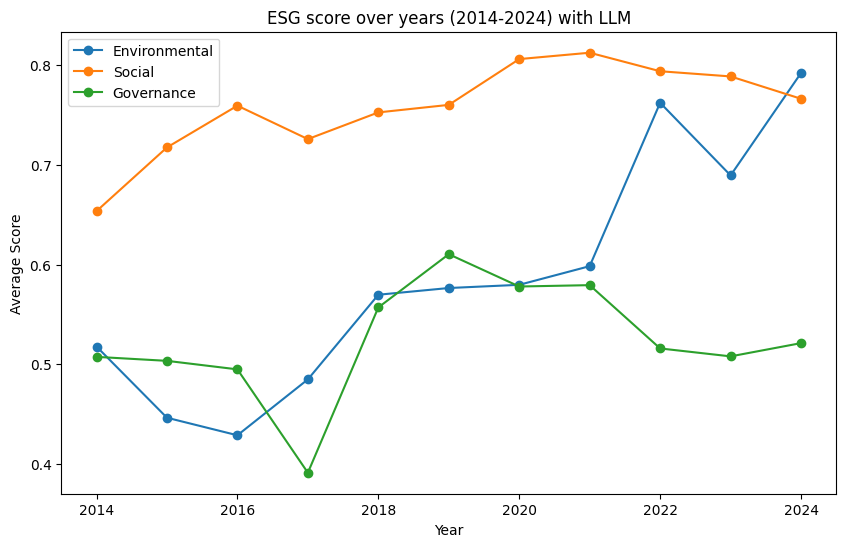

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(target_years, environment_scores, label='Environmental', marker='o')
plt.plot(target_years, social_scores, label='Social', marker='o')
plt.plot(target_years, governance_scores, label='Governance', marker='o')

plt.title("ESG score over years (2014-2024) with LLM")
plt.xlabel("Year")
plt.ylabel("Average Score")
plt.legend()
plt.show()